In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sys


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
yolo_model = torch.hub.load('yolov5', 'custom', path='yolov5/runs/train/card_number_detector6/weights/best.pt', source = 'local').to(device)

YOLOv5 🚀 2024-11-1 Python-3.9.13 torch-2.2.2 CPU

Fusing layers... 
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedDigitCNN(nn.Module):
    def __init__(self):
        super(ImprovedDigitCNN, self).__init__()
        
        # Convolutional Layers with Batch Norm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, 256 * 4 * 4)  # Adjust according to final feature map size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [3]:
cnn_model = ImprovedDigitCNN()
cnn_model.load_state_dict(torch.load('model_checkpoints/model_epoch_30.pth', map_location=device))
cnn_model.to(device)

ImprovedDigitCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

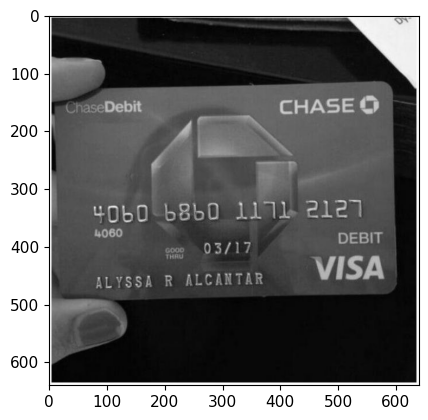

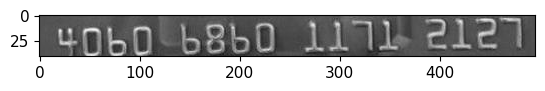

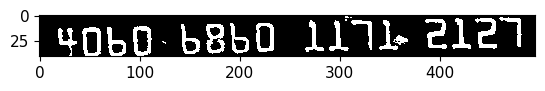

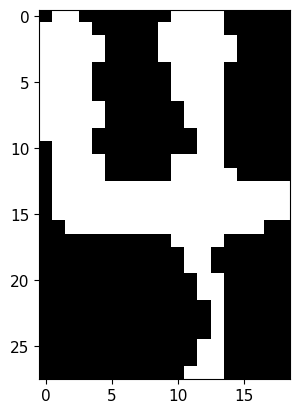

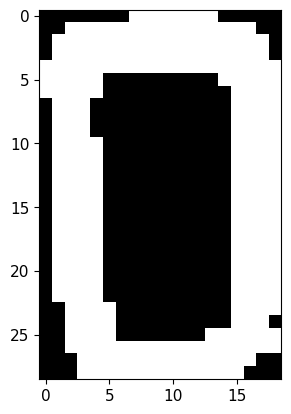

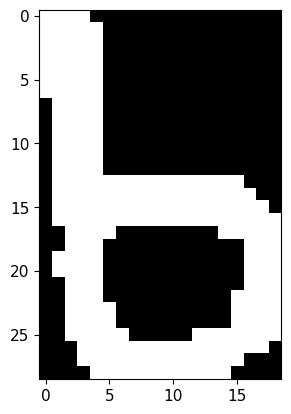

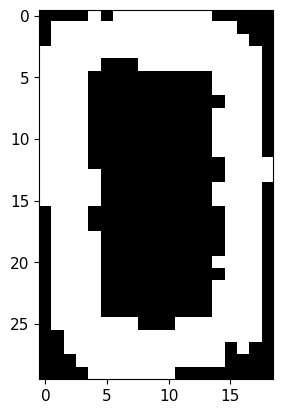

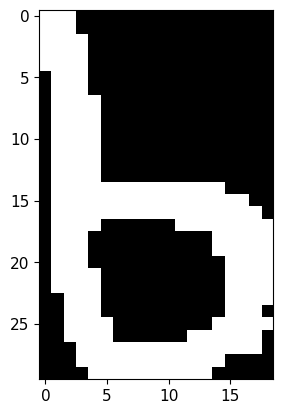

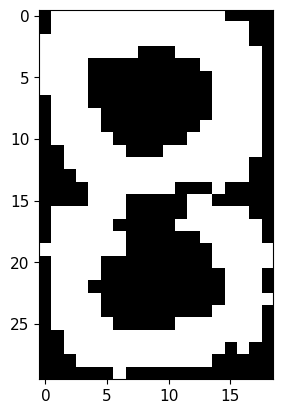

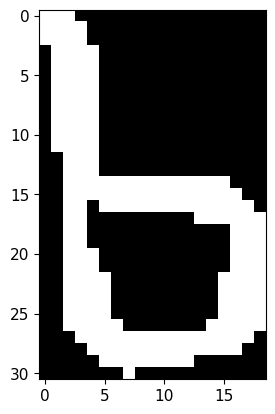

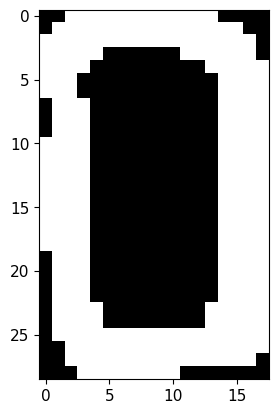

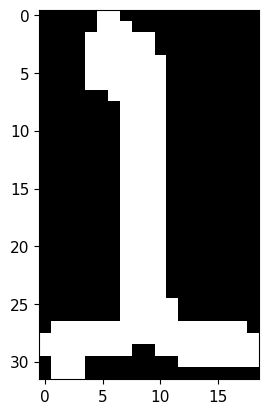

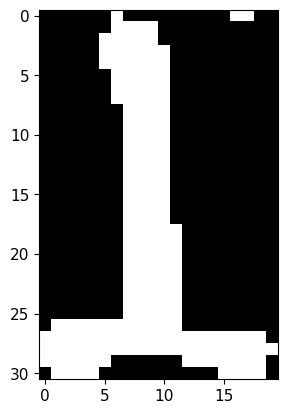

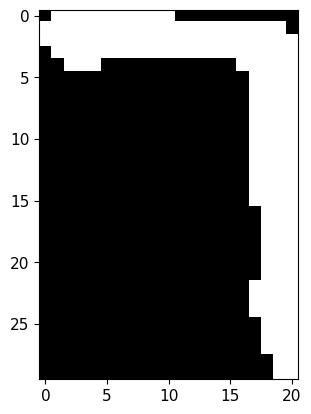

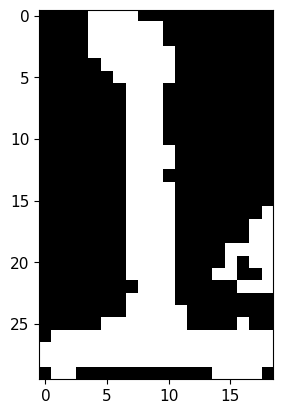

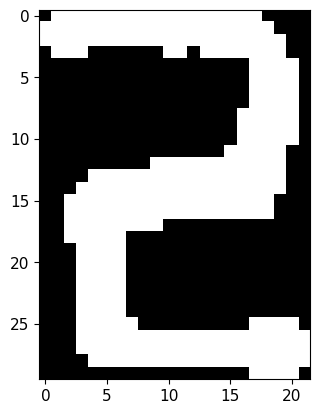

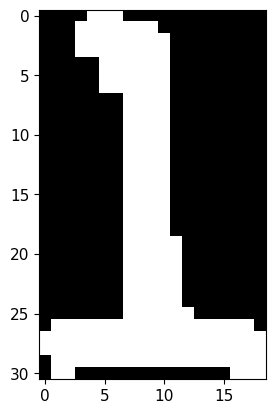

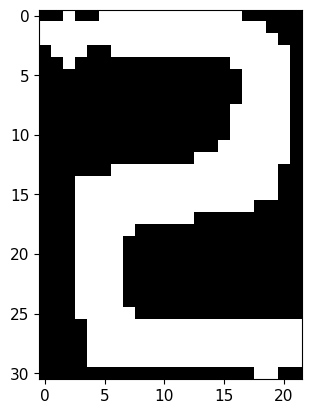

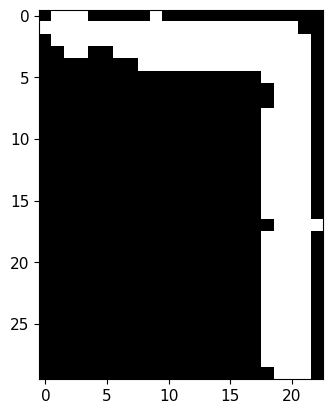

[4, 0, 6, 0, 6, 8, 6, 0, 1, 1, 7, 1, 2, 1, 2, 7]

In [4]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to detect bounding box and recognize digits
def detect_and_recognize_credit_card_number(image_path):
    # Load the image
    image = cv2.imread(image_path)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.axis('on')
    plt.show()

    results = yolo_model(image)

    # Extract the first bounding box (the entire sequence of digits)
    detections = results.pred[0]  # Get the detections for the first image
    if len(detections) > 0:  # Check if any detections are made
        
        box = detections[0][:4].cpu().numpy()  # Get the first bounding box
        x1, y1, x2, y2 = map(int, box)  # Convert to integer coordinates
        
        # Crop the image to the bounding box
        cropped_image = image[y1:y2, x1:x2]  # Crop the digit sequence from the image

        # Display the image
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('on')
        plt.show()    

        # Convert cropped image to grayscale for digit extraction
        gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(gray_image, 110, 255, cv2.THRESH_BINARY_INV)

        binary_image = cv2.adaptiveThreshold(binary_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 11, 2)
        
        # Display the image
        plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('on')
        plt.show()

        # Find contours to separate digits
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Sort contours from left to right based on x-coordinate
        contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
        
        cropped_height = cropped_image.shape[0]
        height_threshold = 0.6 * cropped_height  
        
        digits = []
        
        for cnt in contours:
            # Get bounding box for each contour
            x, y, w, h = cv2.boundingRect(cnt)
            
            if h >= height_threshold:
                digit_image = binary_image[y:y+h, x:x+w]  # Crop the digit
                # Display the image
                plt.imshow(cv2.cvtColor(digit_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
                plt.axis('on')
                plt.show()

                # Resize to fit CNN input (example size: 28x28)
                digit_image = cv2.resize(digit_image, (64, 64))

                # Convert to 3 channels
                digit_image_colored = cv2.cvtColor(digit_image, cv2.COLOR_GRAY2BGR)

                # Normalize and prepare the digit for CNN
                digit_tensor = torch.from_numpy(digit_image_colored).float().permute(2, 0, 1).unsqueeze(0) / 255.0 

                # Normalize and prepare the digit for CNN
                digit_tensor = digit_tensor.to(device)


                # Perform inference with CNN
                with torch.no_grad():
                    output = cnn_model(digit_tensor)
                    _, predicted = torch.max(output, 1)  # Get predicted class

                digits.append(predicted.item())  # Store the predicted digit
        
        return digits  # Return the recognized digits as a list
    else:
        print("No bounding box detected.")
        return []
    
detect_and_recognize_credit_card_number('APS360_Project_Dataset/dataset3_preprocessed/test/images/card15_jpg.rf.cd871d8c66b38063a0de257b0a6356a5.jpg')


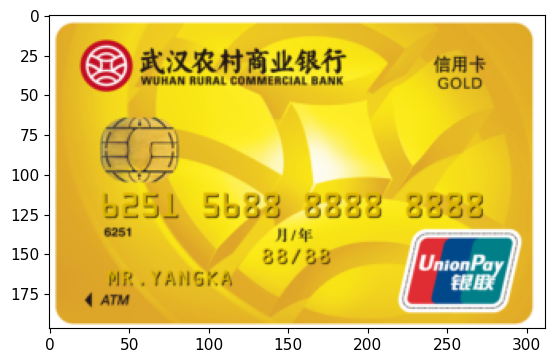

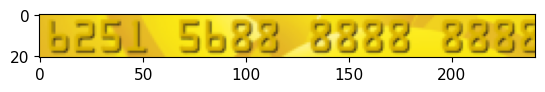

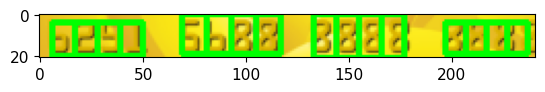

Detected Characters: ['b', 'e', 'S', 'h', 'S', 'b', '8', '8', '8', '8', '8', '8', 'B', 'B', 'B', 'E']
Character Bounding Boxes: [(6, 4, 11, 16), (17, 4, 11, 16), (28, 4, 11, 16), (39, 4, 11, 16), (69, 0, 12, 19), (81, 0, 12, 19), (93, 0, 12, 19), (105, 0, 12, 19), (133, 0, 11, 21), (144, 0, 11, 21), (155, 0, 11, 21), (166, 0, 11, 21), (197, 4, 10, 15), (207, 4, 10, 15), (217, 4, 10, 15), (227, 4, 10, 15)]


In [17]:
import cv2
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt

# Configure the path to Tesseract, if necessary (example for Windows)
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def get_character_boxes(image_path, yolo_model):
    # Load the image
    image = cv2.imread(image_path)
    
    # Display original image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('on')
    plt.show()
    
    # Get YOLO predictions
    results = yolo_model(image)
    detections = results.pred[0]  # Get the detections for the first image
    
    if len(detections) > 0:
        # Extract the first bounding box
        box = detections[0][:4].cpu().numpy()
        x1, y1, x2, y2 = map(int, box)
        
        # Crop the image with padding
        cropped_image = image[y1:y2, x1:x2]
        
        # Display cropped image
        plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        plt.axis('on')
        plt.show()
        
        # Configure Tesseract for character-level detection
        # PSM modes:
        # 6 = Assume a uniform block of text
        # 10 = Treat the image as a single character
        custom_config = r'--oem 3 --psm 13'
        
        # Get character-level data
        data = pytesseract.image_to_data(cropped_image, config=custom_config, output_type=Output.DICT)
        
        # Process character-level information
        char_boxes = []
        text = []
        
        # Iterate through each detected word
        for i in range(len(data['text'])):
            if data['text'][i].strip():  # Check if text is not empty
                word = data['text'][i]
                word_box = (data['left'][i], data['top'][i], 
                          data['width'][i], data['height'][i])
                
                # Calculate approximate character width
                char_width = data['width'][i] // len(word)
                
                # Split word box into character boxes
                for j, char in enumerate(word):
                    char_x = data['left'][i] + (j * char_width)
                    char_y = data['top'][i]
                    char_box = (char_x, char_y, char_width, data['height'][i])
                    char_boxes.append(char_box)
                    text.append(char)
        
        # Draw character boxes on the image
        visualization = cropped_image.copy()
        for box, char in zip(char_boxes, text):
            x, y, w, h = box
            cv2.rectangle(visualization, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(visualization, char, (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display result
        plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
        plt.axis('on')
        plt.show()
        
        return text, char_boxes
    
    return None, None

# Example usage:
image_path = 'APS360_Project_Dataset/dataset5/img/img_1.png'
text, boxes = get_character_boxes(image_path, yolo_model)

if text and boxes:
    print("Detected Characters:", text)
    print("Character Bounding Boxes:", boxes)